# Dataset

In [1]:
!gdown 194DqJkUjjtlUCp7Sd2DkXgwu7SuBFsrj

Downloading...
From (original): https://drive.google.com/uc?id=194DqJkUjjtlUCp7Sd2DkXgwu7SuBFsrj
From (redirected): https://drive.google.com/uc?id=194DqJkUjjtlUCp7Sd2DkXgwu7SuBFsrj&confirm=t&uuid=87f6c778-af62-42db-a1f9-ce34bb504ac8
To: /content/celeba_hq_256.zip
100% 297M/297M [00:02<00:00, 148MB/s]


In [2]:
!unzip celeba_hq_256.zip

Archive:  celeba_hq_256.zip
replace celeba_hq_256/00000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
import os

file_names = os.listdir('./celeba_hq_256')
img_paths = ['./celeba_hq_256/' + file_name for file_name in file_names]
len(img_paths)

30000

In [4]:
import random

sample_size = int(len(img_paths) * 0.9)
train_imgpaths = random.sample(img_paths, sample_size)
val_imgpaths = [img_path for img_path in img_paths if img_path not in train_imgpaths]
train_imgpaths = img_paths[:100]
val_imgpaths = img_paths[:50]

In [5]:
len(train_imgpaths), len(val_imgpaths)

(100, 50)

In [6]:
import numpy as np

def bbox2mask(img_shape, bbox, dtype='uint8'):
    """
    Generate mask in ndarray from bbox.
    bbox (tuple[int]): Configuration tuple, (top, left, height, width)
    """

    height, width = img_shape[:2]

    mask = np.zeros((height, width, 1), dtype=dtype)
    mask[bbox[0]:bbox[0] + bbox[2], bbox[1]:bbox[1] + bbox[3], :] = 1

    return mask

In [7]:
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class InpaintingDataset(Dataset):
    def __init__(self, img_paths, image_size=[256, 256]):
        self.img_paths = img_paths
        self.tfs = transforms.Compose([
                transforms.Resize((image_size[0], image_size[1])),
                transforms.ToTensor(),
                # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5, 0.5])
        ])
        self.image_size = image_size

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path).convert('RGB')
        img = self.tfs(img)
        mask = self.get_mask()
        cond_image = img*(1. - mask) + mask*torch.randn_like(img)
        mask_img = img*(1. - mask) + mask
        return {
            'gt_image': img,
            'cond_image': cond_image,
            'mask_image': mask_img,
            'mask': mask,
            'path': img_path
        }

    def __len__(self):
        return len(self.img_paths)

    def get_mask(self):
        # Center mask
        h, w = self.image_size
        mask = bbox2mask(self.image_size, (h//4, w//4, h//4, w//4))
        return torch.from_numpy(mask).permute(2,0,1)

In [8]:
train_dataset = InpaintingDataset(train_imgpaths)
val_dataset = InpaintingDataset(val_imgpaths)

In [9]:
sample = next(iter(train_dataset))

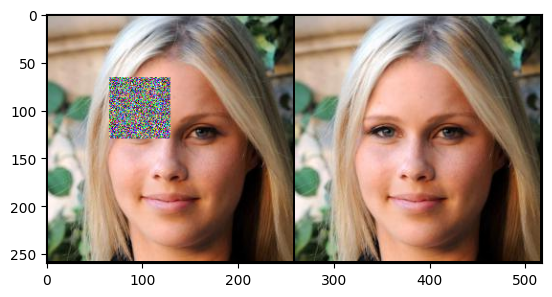

In [10]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

grid = make_grid([sample['cond_image'], sample['gt_image']])
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

In [11]:
import multiprocessing
batch_size = 16
num_workers = 4

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=num_workers, pin_memory=True, prefetch_factor=2
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [12]:
len(train_loader)

6

# Training

In [13]:
! pip install -q torchcfm

In [14]:
from torchcfm.models.unet import UNetModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetModel(dim=(3, 256, 256), num_channels=32, num_res_blocks=1)

import torch.nn as nn
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())

In [15]:
n_epochs = 1000

from tqdm import tqdm
for epoch in range(n_epochs):
    losses = []
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()

        x1 = data['gt_image'].to(device)
        mask = data['mask'].to(device)

        x0 = torch.randn_like(x1).to(device)
        x_noise = (1.0-mask)*x1 + mask*x0

        t = torch.rand(x0.shape[0], 1, 1, 1).to(device)

        xt = t * x1 + (1 - t) * x_noise
        ut = x1 - x_noise

        t = t.squeeze()

        x_cond = xt*mask + (1.0-mask)*x1

        vt = model(t, x_cond)

        loss = torch.mean(((vt - ut) ** 2)*mask)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    print(f"epoch: {epoch}, loss: {avg_loss:.4}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
6it [00:10,  1.67s/it]

epoch: 0, loss: 0.07618



6it [00:05,  1.16it/s]

epoch: 1, loss: 0.0558



6it [00:04,  1.23it/s]

epoch: 2, loss: 0.03941



6it [00:04,  1.48it/s]

epoch: 3, loss: 0.02598



6it [00:03,  1.70it/s]

epoch: 4, loss: 0.01925



6it [00:03,  1.59it/s]

epoch: 5, loss: 0.01441



6it [00:03,  1.71it/s]

epoch: 6, loss: 0.01229



6it [00:03,  1.81it/s]

epoch: 7, loss: 0.01134



6it [00:03,  1.56it/s]

epoch: 8, loss: 0.01243



6it [00:03,  1.69it/s]

epoch: 9, loss: 0.01073



6it [00:03,  1.71it/s]

epoch: 10, loss: 0.008307



6it [00:03,  1.66it/s]

epoch: 11, loss: 0.007924



6it [00:03,  1.65it/s]

epoch: 12, loss: 0.009837



6it [00:03,  1.77it/s]

epoch: 13, loss: 0.006839



6it [00:03,  1.65it/s]

epoch: 14, loss: 0.007554



6it [00:04,  1.47it/s]

epoch: 15, loss: 0.007579



6it [00:03,  1.70it/s]

epoch: 16, loss: 0.006377



6it [00:03,  1.67it/s]

epoch: 17, loss: 0.006594



6it [00:04,  1.48it/s]

epoch: 18, loss: 0.006408



6it [00:03,  1.74it/s]

epoch: 19, loss: 0.006122



6it [00:03,  1.72it/s]

epoch: 20, loss: 0.004542



6it [00:03,  1.68it/s]

epoch: 21, loss: 0.006102



6it [00:04,  1.48it/s]

epoch: 22, loss: 0.005665



6it [00:03,  1.63it/s]

epoch: 23, loss: 0.005387



6it [00:03,  1.56it/s]

epoch: 24, loss: 0.004331



6it [00:03,  1.55it/s]

epoch: 25, loss: 0.005048



6it [00:03,  1.63it/s]

epoch: 26, loss: 0.006357



6it [00:03,  1.57it/s]

epoch: 27, loss: 0.007712



6it [00:04,  1.47it/s]

epoch: 28, loss: 0.006768



6it [00:03,  1.63it/s]

epoch: 29, loss: 0.004472



6it [00:03,  1.68it/s]

epoch: 30, loss: 0.005075



6it [00:03,  1.60it/s]

epoch: 31, loss: 0.005558



6it [00:04,  1.46it/s]

epoch: 32, loss: 0.005011



6it [00:03,  1.62it/s]

epoch: 33, loss: 0.006125



6it [00:03,  1.66it/s]

epoch: 34, loss: 0.004237



6it [00:03,  1.52it/s]

epoch: 35, loss: 0.004679



6it [00:03,  1.63it/s]

epoch: 36, loss: 0.005736



6it [00:03,  1.61it/s]

epoch: 37, loss: 0.005271



6it [00:03,  1.69it/s]

epoch: 38, loss: 0.005623



6it [00:03,  1.64it/s]

epoch: 39, loss: 0.00501



6it [00:03,  1.60it/s]

epoch: 40, loss: 0.004713



6it [00:03,  1.62it/s]

epoch: 41, loss: 0.004347



6it [00:04,  1.49it/s]

epoch: 42, loss: 0.004161



6it [00:03,  1.70it/s]

epoch: 43, loss: 0.004796



6it [00:03,  1.64it/s]

epoch: 44, loss: 0.003948



6it [00:03,  1.51it/s]

epoch: 45, loss: 0.004603



6it [00:03,  1.64it/s]

epoch: 46, loss: 0.00392



6it [00:03,  1.65it/s]

epoch: 47, loss: 0.005205



6it [00:03,  1.59it/s]

epoch: 48, loss: 0.004878



6it [00:03,  1.62it/s]

epoch: 49, loss: 0.005712



6it [00:03,  1.76it/s]

epoch: 50, loss: 0.006068



6it [00:03,  1.63it/s]

epoch: 51, loss: 0.00634



6it [00:03,  1.52it/s]

epoch: 52, loss: 0.004966



6it [00:03,  1.66it/s]

epoch: 53, loss: 0.004459



6it [00:03,  1.64it/s]

epoch: 54, loss: 0.005016



6it [00:03,  1.54it/s]

epoch: 55, loss: 0.006006



6it [00:03,  1.65it/s]

epoch: 56, loss: 0.004943



6it [00:03,  1.62it/s]

epoch: 57, loss: 0.00442



6it [00:03,  1.55it/s]

epoch: 58, loss: 0.004906



6it [00:03,  1.69it/s]

epoch: 59, loss: 0.004551



6it [00:03,  1.65it/s]

epoch: 60, loss: 0.005636



6it [00:03,  1.62it/s]

epoch: 61, loss: 0.005263



6it [00:03,  1.60it/s]

epoch: 62, loss: 0.003945



6it [00:03,  1.63it/s]

epoch: 63, loss: 0.003507



6it [00:03,  1.62it/s]

epoch: 64, loss: 0.0038



6it [00:04,  1.48it/s]

epoch: 65, loss: 0.003814



6it [00:03,  1.63it/s]

epoch: 66, loss: 0.004723



6it [00:03,  1.68it/s]

epoch: 67, loss: 0.004027



6it [00:03,  1.51it/s]

epoch: 68, loss: 0.00309



6it [00:03,  1.65it/s]

epoch: 69, loss: 0.004811



6it [00:03,  1.64it/s]

epoch: 70, loss: 0.00439



6it [00:03,  1.61it/s]

epoch: 71, loss: 0.005112



6it [00:04,  1.46it/s]

epoch: 72, loss: 0.00463



6it [00:03,  1.74it/s]

epoch: 73, loss: 0.003755



6it [00:03,  1.62it/s]

epoch: 74, loss: 0.003632



6it [00:04,  1.47it/s]

epoch: 75, loss: 0.003368



6it [00:03,  1.69it/s]

epoch: 76, loss: 0.003708



6it [00:03,  1.62it/s]

epoch: 77, loss: 0.003328



6it [00:03,  1.58it/s]

epoch: 78, loss: 0.004577



6it [00:03,  1.62it/s]

epoch: 79, loss: 0.003425



6it [00:03,  1.62it/s]

epoch: 80, loss: 0.004275



6it [00:03,  1.63it/s]

epoch: 81, loss: 0.005414



6it [00:03,  1.64it/s]

epoch: 82, loss: 0.003817



6it [00:03,  1.63it/s]

epoch: 83, loss: 0.003191



6it [00:03,  1.66it/s]

epoch: 84, loss: 0.004848



6it [00:04,  1.49it/s]

epoch: 85, loss: 0.0038



6it [00:03,  1.62it/s]

epoch: 86, loss: 0.005956



6it [00:03,  1.58it/s]

epoch: 87, loss: 0.003787



6it [00:03,  1.52it/s]

epoch: 88, loss: 0.00386



6it [00:03,  1.62it/s]

epoch: 89, loss: 0.003861



6it [00:03,  1.63it/s]

epoch: 90, loss: 0.004109



6it [00:03,  1.51it/s]

epoch: 91, loss: 0.004041



6it [00:03,  1.61it/s]

epoch: 92, loss: 0.003078



6it [00:03,  1.69it/s]

epoch: 93, loss: 0.003616



6it [00:03,  1.60it/s]

epoch: 94, loss: 0.003858



6it [00:03,  1.65it/s]

epoch: 95, loss: 0.003288



6it [00:03,  1.67it/s]

epoch: 96, loss: 0.003242



6it [00:03,  1.62it/s]

epoch: 97, loss: 0.003002



6it [00:03,  1.51it/s]

epoch: 98, loss: 0.003224



6it [00:03,  1.67it/s]

epoch: 99, loss: 0.005198



6it [00:03,  1.67it/s]

epoch: 100, loss: 0.004298



6it [00:03,  1.52it/s]

epoch: 101, loss: 0.003686



6it [00:03,  1.63it/s]

epoch: 102, loss: 0.002804



6it [00:03,  1.71it/s]

epoch: 103, loss: 0.003702



6it [00:03,  1.63it/s]

epoch: 104, loss: 0.003421



6it [00:03,  1.61it/s]

epoch: 105, loss: 0.003826



6it [00:03,  1.66it/s]

epoch: 106, loss: 0.003026



6it [00:03,  1.62it/s]

epoch: 107, loss: 0.003095



6it [00:03,  1.50it/s]

epoch: 108, loss: 0.003082



6it [00:03,  1.63it/s]

epoch: 109, loss: 0.003575



6it [00:03,  1.62it/s]

epoch: 110, loss: 0.003281



6it [00:04,  1.42it/s]

epoch: 111, loss: 0.003594



6it [00:03,  1.62it/s]

epoch: 112, loss: 0.004876



6it [00:03,  1.66it/s]

epoch: 113, loss: 0.004488



6it [00:03,  1.59it/s]

epoch: 114, loss: 0.003068



6it [00:03,  1.66it/s]

epoch: 115, loss: 0.004461



6it [00:03,  1.65it/s]

epoch: 116, loss: 0.004617



6it [00:03,  1.58it/s]

epoch: 117, loss: 0.002619



6it [00:04,  1.48it/s]

epoch: 118, loss: 0.003672



6it [00:03,  1.70it/s]

epoch: 119, loss: 0.003997



6it [00:03,  1.61it/s]

epoch: 120, loss: 0.003002



6it [00:03,  1.55it/s]

epoch: 121, loss: 0.003662



6it [00:03,  1.67it/s]

epoch: 122, loss: 0.003554



6it [00:03,  1.68it/s]

epoch: 123, loss: 0.00359



6it [00:03,  1.66it/s]

epoch: 124, loss: 0.003362



6it [00:03,  1.59it/s]

epoch: 125, loss: 0.003912



6it [00:03,  1.62it/s]

epoch: 126, loss: 0.002992



6it [00:03,  1.65it/s]

epoch: 127, loss: 0.0031



6it [00:04,  1.48it/s]

epoch: 128, loss: 0.002607



6it [00:03,  1.64it/s]

epoch: 129, loss: 0.002544



6it [00:03,  1.59it/s]

epoch: 130, loss: 0.003475



6it [00:04,  1.48it/s]

epoch: 131, loss: 0.003673



6it [00:03,  1.65it/s]

epoch: 132, loss: 0.002829



6it [00:03,  1.66it/s]

epoch: 133, loss: 0.003206



6it [00:03,  1.55it/s]

epoch: 134, loss: 0.003366



6it [00:03,  1.65it/s]

epoch: 135, loss: 0.004359



6it [00:03,  1.64it/s]

epoch: 136, loss: 0.003076



6it [00:03,  1.61it/s]

epoch: 137, loss: 0.003831



6it [00:03,  1.61it/s]

epoch: 138, loss: 0.003781



6it [00:03,  1.63it/s]

epoch: 139, loss: 0.003007



6it [00:03,  1.61it/s]

epoch: 140, loss: 0.00289



6it [00:03,  1.52it/s]

epoch: 141, loss: 0.003393



6it [00:03,  1.67it/s]

epoch: 142, loss: 0.003654



6it [00:03,  1.60it/s]

epoch: 143, loss: 0.003438



6it [00:04,  1.46it/s]

epoch: 144, loss: 0.003521



6it [00:03,  1.62it/s]

epoch: 145, loss: 0.0041



6it [00:03,  1.65it/s]

epoch: 146, loss: 0.002983



6it [00:03,  1.64it/s]

epoch: 147, loss: 0.00394



6it [00:03,  1.65it/s]

epoch: 148, loss: 0.003567



6it [00:03,  1.64it/s]

epoch: 149, loss: 0.003006



6it [00:03,  1.63it/s]

epoch: 150, loss: 0.003755



6it [00:04,  1.50it/s]

epoch: 151, loss: 0.002887



6it [00:03,  1.60it/s]

epoch: 152, loss: 0.003832



6it [00:03,  1.59it/s]

epoch: 153, loss: 0.002568



6it [00:03,  1.53it/s]

epoch: 154, loss: 0.003522



6it [00:03,  1.63it/s]

epoch: 155, loss: 0.00267



6it [00:03,  1.66it/s]

epoch: 156, loss: 0.003578



6it [00:04,  1.47it/s]

epoch: 157, loss: 0.002529



6it [00:03,  1.64it/s]

epoch: 158, loss: 0.002706



6it [00:03,  1.73it/s]

epoch: 159, loss: 0.002895



6it [00:03,  1.63it/s]

epoch: 160, loss: 0.003258



6it [00:03,  1.68it/s]

epoch: 161, loss: 0.002565



6it [00:03,  1.63it/s]

epoch: 162, loss: 0.003372



6it [00:03,  1.64it/s]

epoch: 163, loss: 0.002647



6it [00:03,  1.55it/s]

epoch: 164, loss: 0.002209



6it [00:03,  1.65it/s]

epoch: 165, loss: 0.002719



6it [00:03,  1.63it/s]

epoch: 166, loss: 0.002765



6it [00:03,  1.54it/s]

epoch: 167, loss: 0.002405



6it [00:03,  1.69it/s]

epoch: 168, loss: 0.003013



6it [00:03,  1.72it/s]

epoch: 169, loss: 0.003104



6it [00:03,  1.63it/s]

epoch: 170, loss: 0.004825



6it [00:03,  1.66it/s]

epoch: 171, loss: 0.003892



6it [00:03,  1.65it/s]

epoch: 172, loss: 0.00274



6it [00:03,  1.63it/s]

epoch: 173, loss: 0.002549



6it [00:03,  1.51it/s]

epoch: 174, loss: 0.002897



6it [00:03,  1.67it/s]

epoch: 175, loss: 0.003228



6it [00:03,  1.58it/s]

epoch: 176, loss: 0.003187



6it [00:03,  1.51it/s]

epoch: 177, loss: 0.003519



6it [00:03,  1.57it/s]

epoch: 178, loss: 0.002722



6it [00:03,  1.64it/s]

epoch: 179, loss: 0.002968



6it [00:03,  1.55it/s]

epoch: 180, loss: 0.002351



6it [00:03,  1.60it/s]

epoch: 181, loss: 0.003227



6it [00:03,  1.63it/s]

epoch: 182, loss: 0.00292



6it [00:03,  1.61it/s]

epoch: 183, loss: 0.003492



6it [00:03,  1.61it/s]

epoch: 184, loss: 0.002529



6it [00:03,  1.66it/s]

epoch: 185, loss: 0.00219



6it [00:03,  1.65it/s]

epoch: 186, loss: 0.002591



6it [00:03,  1.53it/s]

epoch: 187, loss: 0.003661



6it [00:03,  1.62it/s]

epoch: 188, loss: 0.002901



6it [00:03,  1.64it/s]

epoch: 189, loss: 0.001848



6it [00:03,  1.51it/s]

epoch: 190, loss: 0.002262



6it [00:03,  1.63it/s]

epoch: 191, loss: 0.00229



6it [00:03,  1.53it/s]

epoch: 192, loss: 0.002275



6it [00:03,  1.59it/s]

epoch: 193, loss: 0.002214



6it [00:03,  1.63it/s]

epoch: 194, loss: 0.003446



6it [00:03,  1.61it/s]

epoch: 195, loss: 0.002568



6it [00:03,  1.60it/s]

epoch: 196, loss: 0.003037



6it [00:03,  1.51it/s]

epoch: 197, loss: 0.002548



6it [00:03,  1.61it/s]

epoch: 198, loss: 0.002195



6it [00:03,  1.63it/s]

epoch: 199, loss: 0.003086



6it [00:03,  1.51it/s]

epoch: 200, loss: 0.003024



6it [00:03,  1.64it/s]

epoch: 201, loss: 0.002653



6it [00:03,  1.64it/s]

epoch: 202, loss: 0.00279



6it [00:04,  1.47it/s]

epoch: 203, loss: 0.002576



6it [00:03,  1.60it/s]

epoch: 204, loss: 0.002286



6it [00:03,  1.63it/s]

epoch: 205, loss: 0.003792



6it [00:04,  1.48it/s]

epoch: 206, loss: 0.002756



6it [00:03,  1.69it/s]

epoch: 207, loss: 0.002772



6it [00:03,  1.64it/s]

epoch: 208, loss: 0.003502



6it [00:03,  1.59it/s]

epoch: 209, loss: 0.0036



6it [00:03,  1.62it/s]

epoch: 210, loss: 0.002471



6it [00:03,  1.65it/s]

epoch: 211, loss: 0.002358



6it [00:03,  1.62it/s]

epoch: 212, loss: 0.003463



6it [00:03,  1.51it/s]

epoch: 213, loss: 0.002508



6it [00:03,  1.63it/s]

epoch: 214, loss: 0.002744



6it [00:03,  1.62it/s]

epoch: 215, loss: 0.003332



6it [00:04,  1.44it/s]

epoch: 216, loss: 0.002042



6it [00:03,  1.64it/s]

epoch: 217, loss: 0.004143



6it [00:03,  1.64it/s]

epoch: 218, loss: 0.003033



6it [00:03,  1.58it/s]

epoch: 219, loss: 0.0026



6it [00:03,  1.65it/s]

epoch: 220, loss: 0.003495



6it [00:03,  1.65it/s]

epoch: 221, loss: 0.002414



6it [00:03,  1.65it/s]

epoch: 222, loss: 0.003116



6it [00:03,  1.52it/s]

epoch: 223, loss: 0.003185



6it [00:03,  1.63it/s]

epoch: 224, loss: 0.002477



6it [00:04,  1.49it/s]

epoch: 225, loss: 0.002837



6it [00:03,  1.51it/s]

epoch: 226, loss: 0.002361



6it [00:03,  1.73it/s]

epoch: 227, loss: 0.002161



6it [00:03,  1.61it/s]

epoch: 228, loss: 0.002323



6it [00:04,  1.42it/s]

epoch: 229, loss: 0.002564



6it [00:03,  1.70it/s]

epoch: 230, loss: 0.002093



6it [00:03,  1.63it/s]

epoch: 231, loss: 0.003063



6it [00:04,  1.47it/s]

epoch: 232, loss: 0.002288



6it [00:03,  1.65it/s]

epoch: 233, loss: 0.002584



6it [00:03,  1.62it/s]

epoch: 234, loss: 0.001983



6it [00:03,  1.63it/s]

epoch: 235, loss: 0.002958



6it [00:03,  1.50it/s]

epoch: 236, loss: 0.003229



6it [00:03,  1.60it/s]

epoch: 237, loss: 0.001824



6it [00:03,  1.59it/s]

epoch: 238, loss: 0.003386



6it [00:04,  1.49it/s]

epoch: 239, loss: 0.002337



6it [00:03,  1.62it/s]

epoch: 240, loss: 0.002813



6it [00:03,  1.63it/s]

epoch: 241, loss: 0.002203



6it [00:03,  1.51it/s]

epoch: 242, loss: 0.002772



6it [00:03,  1.63it/s]

epoch: 243, loss: 0.002286



6it [00:03,  1.67it/s]

epoch: 244, loss: 0.0024



6it [00:03,  1.63it/s]

epoch: 245, loss: 0.001979



6it [00:03,  1.62it/s]

epoch: 246, loss: 0.002914



6it [00:03,  1.61it/s]

epoch: 247, loss: 0.002565



6it [00:03,  1.60it/s]

epoch: 248, loss: 0.003719



6it [00:04,  1.50it/s]

epoch: 249, loss: 0.003877



6it [00:03,  1.68it/s]

epoch: 250, loss: 0.002557



6it [00:03,  1.59it/s]

epoch: 251, loss: 0.002137



6it [00:04,  1.49it/s]

epoch: 252, loss: 0.002195



6it [00:03,  1.68it/s]

epoch: 253, loss: 0.003214



6it [00:03,  1.66it/s]

epoch: 254, loss: 0.001813



6it [00:03,  1.51it/s]

epoch: 255, loss: 0.002945



6it [00:03,  1.62it/s]

epoch: 256, loss: 0.002036



6it [00:03,  1.61it/s]

epoch: 257, loss: 0.002336



6it [00:03,  1.60it/s]

epoch: 258, loss: 0.002023



6it [00:03,  1.58it/s]

epoch: 259, loss: 0.00213



6it [00:03,  1.60it/s]

epoch: 260, loss: 0.002473



6it [00:03,  1.61it/s]

epoch: 261, loss: 0.002757



6it [00:03,  1.52it/s]

epoch: 262, loss: 0.002431



6it [00:03,  1.62it/s]

epoch: 263, loss: 0.00282



6it [00:03,  1.60it/s]

epoch: 264, loss: 0.002087



6it [00:04,  1.45it/s]

epoch: 265, loss: 0.002731



6it [00:03,  1.63it/s]

epoch: 266, loss: 0.002235



6it [00:03,  1.62it/s]

epoch: 267, loss: 0.001804



6it [00:03,  1.50it/s]

epoch: 268, loss: 0.004507



6it [00:03,  1.64it/s]

epoch: 269, loss: 0.002061



6it [00:03,  1.62it/s]

epoch: 270, loss: 0.003171



6it [00:03,  1.53it/s]

epoch: 271, loss: 0.002799



6it [00:04,  1.41it/s]

epoch: 272, loss: 0.001716



6it [00:03,  1.66it/s]

epoch: 273, loss: 0.002255



6it [00:03,  1.62it/s]

epoch: 274, loss: 0.002424



6it [00:04,  1.49it/s]

epoch: 275, loss: 0.00201



6it [00:03,  1.62it/s]

epoch: 276, loss: 0.002399



6it [00:03,  1.61it/s]

epoch: 277, loss: 0.002556



6it [00:04,  1.49it/s]

epoch: 278, loss: 0.002437



6it [00:03,  1.61it/s]

epoch: 279, loss: 0.002701



6it [00:03,  1.60it/s]

epoch: 280, loss: 0.002348



6it [00:03,  1.65it/s]

epoch: 281, loss: 0.002427



6it [00:03,  1.63it/s]

epoch: 282, loss: 0.003758



6it [00:03,  1.65it/s]

epoch: 283, loss: 0.002641



6it [00:03,  1.62it/s]

epoch: 284, loss: 0.002804



6it [00:03,  1.60it/s]

epoch: 285, loss: 0.002063



6it [00:03,  1.58it/s]

epoch: 286, loss: 0.002796



6it [00:03,  1.59it/s]

epoch: 287, loss: 0.002305



6it [00:04,  1.50it/s]

epoch: 288, loss: 0.001898



6it [00:03,  1.63it/s]

epoch: 289, loss: 0.002231



6it [00:03,  1.63it/s]

epoch: 290, loss: 0.001643



6it [00:04,  1.45it/s]

epoch: 291, loss: 0.002584



6it [00:03,  1.61it/s]

epoch: 292, loss: 0.001733



6it [00:03,  1.65it/s]

epoch: 293, loss: 0.00307



6it [00:03,  1.67it/s]

epoch: 294, loss: 0.002855



6it [00:03,  1.60it/s]

epoch: 295, loss: 0.002346



6it [00:03,  1.60it/s]

epoch: 296, loss: 0.002944



6it [00:03,  1.66it/s]

epoch: 297, loss: 0.00221



6it [00:04,  1.49it/s]

epoch: 298, loss: 0.002117



6it [00:03,  1.65it/s]

epoch: 299, loss: 0.0021



6it [00:03,  1.61it/s]

epoch: 300, loss: 0.002602



6it [00:03,  1.53it/s]

epoch: 301, loss: 0.002721



6it [00:03,  1.64it/s]

epoch: 302, loss: 0.002321



6it [00:03,  1.61it/s]

epoch: 303, loss: 0.002338



6it [00:03,  1.50it/s]

epoch: 304, loss: 0.00235



6it [00:03,  1.62it/s]

epoch: 305, loss: 0.00253



6it [00:03,  1.61it/s]

epoch: 306, loss: 0.001803



6it [00:03,  1.67it/s]

epoch: 307, loss: 0.001772



6it [00:03,  1.64it/s]

epoch: 308, loss: 0.001935



6it [00:03,  1.70it/s]

epoch: 309, loss: 0.001968



6it [00:03,  1.61it/s]

epoch: 310, loss: 0.002503



6it [00:04,  1.46it/s]

epoch: 311, loss: 0.003084



6it [00:04,  1.48it/s]

epoch: 312, loss: 0.001882



6it [00:03,  1.60it/s]

epoch: 313, loss: 0.001504



6it [00:04,  1.46it/s]

epoch: 314, loss: 0.001543



6it [00:03,  1.68it/s]

epoch: 315, loss: 0.001887



6it [00:03,  1.70it/s]

epoch: 316, loss: 0.001999



6it [00:03,  1.54it/s]

epoch: 317, loss: 0.001923



6it [00:03,  1.63it/s]

epoch: 318, loss: 0.001912



6it [00:03,  1.64it/s]

epoch: 319, loss: 0.001461



6it [00:03,  1.60it/s]

epoch: 320, loss: 0.001907



6it [00:03,  1.64it/s]

epoch: 321, loss: 0.002372



6it [00:03,  1.69it/s]

epoch: 322, loss: 0.001425



6it [00:03,  1.70it/s]

epoch: 323, loss: 0.002347



6it [00:03,  1.52it/s]

epoch: 324, loss: 0.002607



6it [00:03,  1.65it/s]

epoch: 325, loss: 0.002564



6it [00:03,  1.61it/s]

epoch: 326, loss: 0.002831



6it [00:04,  1.48it/s]

epoch: 327, loss: 0.002401



6it [00:03,  1.64it/s]

epoch: 328, loss: 0.001838



6it [00:03,  1.62it/s]

epoch: 329, loss: 0.0014



6it [00:03,  1.61it/s]

epoch: 330, loss: 0.001613



6it [00:03,  1.62it/s]

epoch: 331, loss: 0.001836



6it [00:03,  1.61it/s]

epoch: 332, loss: 0.001929



6it [00:03,  1.58it/s]

epoch: 333, loss: 0.002135



6it [00:03,  1.64it/s]

epoch: 334, loss: 0.003148



6it [00:03,  1.62it/s]

epoch: 335, loss: 0.002044



6it [00:03,  1.65it/s]

epoch: 336, loss: 0.001745



6it [00:04,  1.48it/s]

epoch: 337, loss: 0.002138



6it [00:03,  1.64it/s]

epoch: 338, loss: 0.001968



6it [00:03,  1.60it/s]

epoch: 339, loss: 0.002003



6it [00:04,  1.44it/s]

epoch: 340, loss: 0.001605



6it [00:03,  1.64it/s]

epoch: 341, loss: 0.002033



6it [00:03,  1.67it/s]

epoch: 342, loss: 0.002031



6it [00:03,  1.66it/s]

epoch: 343, loss: 0.00246



6it [00:03,  1.64it/s]

epoch: 344, loss: 0.00182



6it [00:03,  1.63it/s]

epoch: 345, loss: 0.001316



6it [00:03,  1.61it/s]

epoch: 346, loss: 0.001882



6it [00:03,  1.55it/s]

epoch: 347, loss: 0.003078



6it [00:03,  1.57it/s]

epoch: 348, loss: 0.003543



6it [00:03,  1.66it/s]

epoch: 349, loss: 0.001635



6it [00:04,  1.48it/s]

epoch: 350, loss: 0.002015



6it [00:03,  1.61it/s]

epoch: 351, loss: 0.002326



6it [00:04,  1.45it/s]

epoch: 352, loss: 0.0023



6it [00:04,  1.48it/s]

epoch: 353, loss: 0.002929



6it [00:03,  1.62it/s]

epoch: 354, loss: 0.002163



6it [00:03,  1.61it/s]

epoch: 355, loss: 0.002736



6it [00:04,  1.46it/s]

epoch: 356, loss: 0.002321



6it [00:03,  1.62it/s]

epoch: 357, loss: 0.002415



6it [00:03,  1.65it/s]

epoch: 358, loss: 0.0028



6it [00:03,  1.56it/s]

epoch: 359, loss: 0.002231



6it [00:03,  1.63it/s]

epoch: 360, loss: 0.003027



6it [00:03,  1.60it/s]

epoch: 361, loss: 0.002687



6it [00:03,  1.58it/s]

epoch: 362, loss: 0.00187



6it [00:03,  1.61it/s]

epoch: 363, loss: 0.002232



6it [00:03,  1.60it/s]

epoch: 364, loss: 0.002132



6it [00:03,  1.68it/s]

epoch: 365, loss: 0.004285



6it [00:04,  1.49it/s]

epoch: 366, loss: 0.002132



6it [00:03,  1.69it/s]

epoch: 367, loss: 0.001994



6it [00:03,  1.59it/s]

epoch: 368, loss: 0.002968



6it [00:03,  1.52it/s]

epoch: 369, loss: 0.002597



6it [00:03,  1.61it/s]

epoch: 370, loss: 0.001835



6it [00:03,  1.64it/s]

epoch: 371, loss: 0.002579



6it [00:03,  1.59it/s]

epoch: 372, loss: 0.002257



6it [00:03,  1.62it/s]

epoch: 373, loss: 0.001592



6it [00:03,  1.62it/s]

epoch: 374, loss: 0.002371



6it [00:03,  1.57it/s]

epoch: 375, loss: 0.001774



6it [00:03,  1.65it/s]

epoch: 376, loss: 0.002136



6it [00:03,  1.61it/s]

epoch: 377, loss: 0.002844



6it [00:03,  1.58it/s]

epoch: 378, loss: 0.002897



6it [00:04,  1.50it/s]

epoch: 379, loss: 0.001306



6it [00:03,  1.66it/s]

epoch: 380, loss: 0.001401



6it [00:03,  1.62it/s]

epoch: 381, loss: 0.00281



6it [00:03,  1.52it/s]

epoch: 382, loss: 0.001556



6it [00:03,  1.66it/s]

epoch: 383, loss: 0.001787



6it [00:03,  1.60it/s]

epoch: 384, loss: 0.001555



6it [00:03,  1.52it/s]

epoch: 385, loss: 0.002131



6it [00:03,  1.66it/s]

epoch: 386, loss: 0.001667



6it [00:03,  1.64it/s]

epoch: 387, loss: 0.001732



6it [00:03,  1.61it/s]

epoch: 388, loss: 0.001192



6it [00:03,  1.65it/s]

epoch: 389, loss: 0.002239



6it [00:03,  1.64it/s]

epoch: 390, loss: 0.001254



6it [00:03,  1.62it/s]

epoch: 391, loss: 0.002049



6it [00:03,  1.56it/s]

epoch: 392, loss: 0.00226



6it [00:03,  1.51it/s]

epoch: 393, loss: 0.00196



6it [00:03,  1.55it/s]


epoch: 394, loss: 0.001674


6it [00:04,  1.47it/s]

epoch: 395, loss: 0.00171



6it [00:03,  1.66it/s]

epoch: 396, loss: 0.001389



6it [00:03,  1.58it/s]

epoch: 397, loss: 0.002136



6it [00:03,  1.53it/s]

epoch: 398, loss: 0.003945



6it [00:03,  1.61it/s]

epoch: 399, loss: 0.002101



6it [00:03,  1.65it/s]

epoch: 400, loss: 0.002016



6it [00:03,  1.68it/s]

epoch: 401, loss: 0.002375



6it [00:03,  1.61it/s]

epoch: 402, loss: 0.002287



6it [00:03,  1.64it/s]

epoch: 403, loss: 0.001771



6it [00:03,  1.60it/s]

epoch: 404, loss: 0.002075



6it [00:03,  1.54it/s]

epoch: 405, loss: 0.002412



6it [00:03,  1.61it/s]

epoch: 406, loss: 0.001715



6it [00:03,  1.55it/s]

epoch: 407, loss: 0.002039



6it [00:03,  1.50it/s]

epoch: 408, loss: 0.001109



6it [00:03,  1.62it/s]

epoch: 409, loss: 0.002236



6it [00:03,  1.58it/s]

epoch: 410, loss: 0.002285



6it [00:04,  1.46it/s]

epoch: 411, loss: 0.001779



6it [00:03,  1.63it/s]

epoch: 412, loss: 0.002075



6it [00:03,  1.67it/s]

epoch: 413, loss: 0.002144



6it [00:03,  1.60it/s]

epoch: 414, loss: 0.001436



6it [00:03,  1.68it/s]

epoch: 415, loss: 0.001743



6it [00:03,  1.62it/s]

epoch: 416, loss: 0.002086



6it [00:03,  1.71it/s]

epoch: 417, loss: 0.00239



6it [00:04,  1.50it/s]

epoch: 418, loss: 0.001935



6it [00:03,  1.67it/s]

epoch: 419, loss: 0.001984



6it [00:03,  1.64it/s]

epoch: 420, loss: 0.002915



6it [00:04,  1.45it/s]

epoch: 421, loss: 0.001201



6it [00:03,  1.63it/s]

epoch: 422, loss: 0.001631



6it [00:03,  1.62it/s]

epoch: 423, loss: 0.001677



6it [00:03,  1.56it/s]

epoch: 424, loss: 0.002132



6it [00:03,  1.62it/s]

epoch: 425, loss: 0.002545



6it [00:03,  1.69it/s]

epoch: 426, loss: 0.003569



6it [00:03,  1.61it/s]

epoch: 427, loss: 0.001997



6it [00:03,  1.64it/s]

epoch: 428, loss: 0.001736



6it [00:03,  1.71it/s]

epoch: 429, loss: 0.002944



6it [00:03,  1.60it/s]

epoch: 430, loss: 0.002256



6it [00:04,  1.49it/s]

epoch: 431, loss: 0.002361



6it [00:03,  1.63it/s]

epoch: 432, loss: 0.002168



6it [00:03,  1.62it/s]

epoch: 433, loss: 0.001713



6it [00:03,  1.54it/s]

epoch: 434, loss: 0.001789



6it [00:03,  1.63it/s]

epoch: 435, loss: 0.001763



6it [00:03,  1.72it/s]

epoch: 436, loss: 0.002911



6it [00:03,  1.61it/s]

epoch: 437, loss: 0.003184



6it [00:03,  1.61it/s]

epoch: 438, loss: 0.002366



6it [00:03,  1.61it/s]

epoch: 439, loss: 0.002382



6it [00:03,  1.58it/s]

epoch: 440, loss: 0.001686



6it [00:03,  1.51it/s]

epoch: 441, loss: 0.002649



6it [00:03,  1.67it/s]

epoch: 442, loss: 0.002223



6it [00:03,  1.60it/s]

epoch: 443, loss: 0.001837



6it [00:04,  1.48it/s]

epoch: 444, loss: 0.002407



6it [00:03,  1.61it/s]

epoch: 445, loss: 0.00183



6it [00:03,  1.59it/s]

epoch: 446, loss: 0.001848



6it [00:03,  1.55it/s]

epoch: 447, loss: 0.001846



6it [00:03,  1.63it/s]

epoch: 448, loss: 0.001675



6it [00:03,  1.66it/s]

epoch: 449, loss: 0.001687



6it [00:03,  1.64it/s]

epoch: 450, loss: 0.002459



6it [00:03,  1.65it/s]

epoch: 451, loss: 0.002748



6it [00:03,  1.62it/s]

epoch: 452, loss: 0.001825



6it [00:03,  1.63it/s]

epoch: 453, loss: 0.001932



6it [00:03,  1.51it/s]

epoch: 454, loss: 0.001811



6it [00:03,  1.64it/s]

epoch: 455, loss: 0.002827



6it [00:03,  1.56it/s]

epoch: 456, loss: 0.002659



6it [00:04,  1.48it/s]

epoch: 457, loss: 0.00196



6it [00:03,  1.66it/s]

epoch: 458, loss: 0.00402



6it [00:03,  1.64it/s]

epoch: 459, loss: 0.001804



6it [00:04,  1.48it/s]

epoch: 460, loss: 0.002909



6it [00:03,  1.62it/s]

epoch: 461, loss: 0.001203



6it [00:03,  1.62it/s]

epoch: 462, loss: 0.001005



6it [00:03,  1.60it/s]

epoch: 463, loss: 0.001164



6it [00:03,  1.59it/s]

epoch: 464, loss: 0.001645



6it [00:03,  1.64it/s]

epoch: 465, loss: 0.001913



6it [00:03,  1.59it/s]

epoch: 466, loss: 0.0022



6it [00:03,  1.59it/s]

epoch: 467, loss: 0.001594



6it [00:03,  1.64it/s]

epoch: 468, loss: 0.001552



6it [00:03,  1.60it/s]

epoch: 469, loss: 0.0008036



6it [00:03,  1.51it/s]

epoch: 470, loss: 0.002196



6it [00:03,  1.63it/s]

epoch: 471, loss: 0.001772



6it [00:03,  1.60it/s]

epoch: 472, loss: 0.0009339



6it [00:04,  1.49it/s]

epoch: 473, loss: 0.002756



6it [00:04,  1.47it/s]

epoch: 474, loss: 0.001388



6it [00:03,  1.60it/s]

epoch: 475, loss: 0.001601



6it [00:03,  1.58it/s]

epoch: 476, loss: 0.001694



6it [00:03,  1.62it/s]

epoch: 477, loss: 0.001677



6it [00:03,  1.70it/s]

epoch: 478, loss: 0.001212



6it [00:03,  1.67it/s]

epoch: 479, loss: 0.0008186



6it [00:03,  1.64it/s]

epoch: 480, loss: 0.001621



6it [00:03,  1.62it/s]

epoch: 481, loss: 0.002581



6it [00:03,  1.59it/s]

epoch: 482, loss: 0.001205



6it [00:04,  1.47it/s]

epoch: 483, loss: 0.001493



6it [00:03,  1.60it/s]

epoch: 484, loss: 0.001436



6it [00:03,  1.59it/s]

epoch: 485, loss: 0.001678



6it [00:03,  1.56it/s]

epoch: 486, loss: 0.001074



6it [00:03,  1.65it/s]

epoch: 487, loss: 0.00162



6it [00:03,  1.61it/s]

epoch: 488, loss: 0.002111



6it [00:03,  1.52it/s]

epoch: 489, loss: 0.002057



6it [00:03,  1.66it/s]

epoch: 490, loss: 0.001517



6it [00:03,  1.63it/s]

epoch: 491, loss: 0.001565



6it [00:03,  1.61it/s]

epoch: 492, loss: 0.00234



6it [00:03,  1.67it/s]

epoch: 493, loss: 0.00177



6it [00:03,  1.61it/s]

epoch: 494, loss: 0.001974



6it [00:03,  1.68it/s]

epoch: 495, loss: 0.001311



6it [00:04,  1.48it/s]

epoch: 496, loss: 0.001995



6it [00:03,  1.61it/s]

epoch: 497, loss: 0.001868



6it [00:03,  1.64it/s]

epoch: 498, loss: 0.003031



6it [00:04,  1.48it/s]

epoch: 499, loss: 0.001718



6it [00:03,  1.63it/s]

epoch: 500, loss: 0.002239



6it [00:03,  1.61it/s]

epoch: 501, loss: 0.002541



6it [00:04,  1.45it/s]

epoch: 502, loss: 0.001456



6it [00:03,  1.62it/s]

epoch: 503, loss: 0.002442



6it [00:03,  1.61it/s]

epoch: 504, loss: 0.00225



6it [00:03,  1.62it/s]

epoch: 505, loss: 0.00274



6it [00:03,  1.65it/s]

epoch: 506, loss: 0.001898



6it [00:03,  1.63it/s]

epoch: 507, loss: 0.002342



6it [00:03,  1.65it/s]

epoch: 508, loss: 0.003419



6it [00:04,  1.50it/s]

epoch: 509, loss: 0.00214



6it [00:03,  1.60it/s]

epoch: 510, loss: 0.001681



6it [00:03,  1.60it/s]

epoch: 511, loss: 0.001278



6it [00:04,  1.50it/s]

epoch: 512, loss: 0.002767



6it [00:03,  1.62it/s]

epoch: 513, loss: 0.002529



6it [00:04,  1.47it/s]

epoch: 514, loss: 0.0029



6it [00:04,  1.44it/s]

epoch: 515, loss: 0.001634



6it [00:03,  1.60it/s]

epoch: 516, loss: 0.001801



6it [00:03,  1.65it/s]

epoch: 517, loss: 0.002886



6it [00:03,  1.56it/s]

epoch: 518, loss: 0.002032



6it [00:03,  1.64it/s]

epoch: 519, loss: 0.001814



6it [00:03,  1.65it/s]

epoch: 520, loss: 0.001573



6it [00:03,  1.68it/s]

epoch: 521, loss: 0.001718



6it [00:03,  1.57it/s]

epoch: 522, loss: 0.00174



6it [00:03,  1.62it/s]

epoch: 523, loss: 0.002664



6it [00:03,  1.57it/s]

epoch: 524, loss: 0.001647



6it [00:03,  1.56it/s]

epoch: 525, loss: 0.001404



6it [00:03,  1.61it/s]

epoch: 526, loss: 0.001801



6it [00:03,  1.64it/s]

epoch: 527, loss: 0.002092



6it [00:04,  1.47it/s]

epoch: 528, loss: 0.001148



6it [00:03,  1.67it/s]

epoch: 529, loss: 0.001126



6it [00:03,  1.62it/s]

epoch: 530, loss: 0.00139



6it [00:03,  1.57it/s]

epoch: 531, loss: 0.001863



6it [00:03,  1.59it/s]

epoch: 532, loss: 0.001842



6it [00:03,  1.59it/s]

epoch: 533, loss: 0.001002



6it [00:03,  1.58it/s]

epoch: 534, loss: 0.001536



6it [00:03,  1.62it/s]

epoch: 535, loss: 0.00113



6it [00:03,  1.63it/s]

epoch: 536, loss: 0.001553



6it [00:03,  1.62it/s]

epoch: 537, loss: 0.00213



6it [00:03,  1.54it/s]

epoch: 538, loss: 0.001412



6it [00:03,  1.61it/s]

epoch: 539, loss: 0.001448



6it [00:03,  1.58it/s]

epoch: 540, loss: 0.001541



6it [00:04,  1.48it/s]

epoch: 541, loss: 0.001578



6it [00:03,  1.65it/s]

epoch: 542, loss: 0.001263



6it [00:03,  1.63it/s]

epoch: 543, loss: 0.001674



6it [00:03,  1.58it/s]

epoch: 544, loss: 0.001494



6it [00:03,  1.65it/s]

epoch: 545, loss: 0.00199



6it [00:03,  1.63it/s]

epoch: 546, loss: 0.001552



6it [00:03,  1.64it/s]

epoch: 547, loss: 0.002281



6it [00:03,  1.55it/s]

epoch: 548, loss: 0.001296



6it [00:03,  1.63it/s]

epoch: 549, loss: 0.001483



6it [00:03,  1.60it/s]

epoch: 550, loss: 0.001235



6it [00:03,  1.56it/s]

epoch: 551, loss: 0.001787



6it [00:03,  1.63it/s]

epoch: 552, loss: 0.002545



6it [00:03,  1.65it/s]

epoch: 553, loss: 0.00169



6it [00:03,  1.53it/s]

epoch: 554, loss: 0.001739



6it [00:03,  1.51it/s]

epoch: 555, loss: 0.001648



6it [00:03,  1.61it/s]

epoch: 556, loss: 0.001107



6it [00:03,  1.51it/s]

epoch: 557, loss: 0.001409



6it [00:03,  1.61it/s]

epoch: 558, loss: 0.002309



6it [00:03,  1.61it/s]

epoch: 559, loss: 0.001832



6it [00:03,  1.64it/s]

epoch: 560, loss: 0.001293



6it [00:03,  1.64it/s]

epoch: 561, loss: 0.001674



6it [00:03,  1.63it/s]

epoch: 562, loss: 0.001081



6it [00:03,  1.63it/s]

epoch: 563, loss: 0.001912



6it [00:03,  1.52it/s]

epoch: 564, loss: 0.001306



6it [00:03,  1.62it/s]

epoch: 565, loss: 0.001288



6it [00:03,  1.58it/s]

epoch: 566, loss: 0.001505



6it [00:04,  1.45it/s]

epoch: 567, loss: 0.001714



6it [00:03,  1.60it/s]

epoch: 568, loss: 0.002231



6it [00:03,  1.61it/s]

epoch: 569, loss: 0.001521



6it [00:03,  1.55it/s]

epoch: 570, loss: 0.002379



6it [00:03,  1.65it/s]

epoch: 571, loss: 0.002402



6it [00:03,  1.60it/s]

epoch: 572, loss: 0.001743



6it [00:03,  1.60it/s]

epoch: 573, loss: 0.002032



6it [00:03,  1.59it/s]

epoch: 574, loss: 0.001825



6it [00:03,  1.72it/s]

epoch: 575, loss: 0.002297



6it [00:03,  1.64it/s]

epoch: 576, loss: 0.001594



6it [00:04,  1.47it/s]

epoch: 577, loss: 0.001444



6it [00:03,  1.64it/s]

epoch: 578, loss: 0.001228



6it [00:03,  1.58it/s]

epoch: 579, loss: 0.001289



6it [00:04,  1.46it/s]

epoch: 580, loss: 0.003057



6it [00:03,  1.65it/s]

epoch: 581, loss: 0.0018



6it [00:03,  1.66it/s]

epoch: 582, loss: 0.00302



6it [00:03,  1.58it/s]

epoch: 583, loss: 0.002558



6it [00:03,  1.61it/s]

epoch: 584, loss: 0.002524



6it [00:03,  1.61it/s]

epoch: 585, loss: 0.001569



6it [00:03,  1.64it/s]

epoch: 586, loss: 0.001369



6it [00:03,  1.60it/s]

epoch: 587, loss: 0.001598



6it [00:03,  1.68it/s]

epoch: 588, loss: 0.00122



6it [00:03,  1.71it/s]

epoch: 589, loss: 0.002069



6it [00:04,  1.46it/s]

epoch: 590, loss: 0.001943



6it [00:03,  1.61it/s]

epoch: 591, loss: 0.001593



6it [00:03,  1.64it/s]

epoch: 592, loss: 0.001007



6it [00:03,  1.54it/s]

epoch: 593, loss: 0.002597



6it [00:03,  1.61it/s]

epoch: 594, loss: 0.001427



6it [00:03,  1.58it/s]

epoch: 595, loss: 0.002328



6it [00:04,  1.50it/s]

epoch: 596, loss: 0.001658



6it [00:04,  1.50it/s]

epoch: 597, loss: 0.001707



6it [00:03,  1.65it/s]

epoch: 598, loss: 0.002128



6it [00:03,  1.58it/s]

epoch: 599, loss: 0.001012



6it [00:04,  1.48it/s]

epoch: 600, loss: 0.001185



6it [00:03,  1.64it/s]

epoch: 601, loss: 0.001836



6it [00:03,  1.62it/s]

epoch: 602, loss: 0.001719



6it [00:04,  1.48it/s]

epoch: 603, loss: 0.001411



6it [00:03,  1.64it/s]

epoch: 604, loss: 0.002315



6it [00:03,  1.62it/s]

epoch: 605, loss: 0.001874



6it [00:03,  1.55it/s]

epoch: 606, loss: 0.001744



6it [00:03,  1.62it/s]

epoch: 607, loss: 0.00153



6it [00:03,  1.66it/s]

epoch: 608, loss: 0.001321



6it [00:03,  1.60it/s]

epoch: 609, loss: 0.002067



6it [00:03,  1.67it/s]

epoch: 610, loss: 0.001589



6it [00:03,  1.63it/s]

epoch: 611, loss: 0.0009883



6it [00:03,  1.60it/s]

epoch: 612, loss: 0.002301



6it [00:03,  1.54it/s]

epoch: 613, loss: 0.001706



6it [00:03,  1.68it/s]

epoch: 614, loss: 0.001165



6it [00:03,  1.63it/s]

epoch: 615, loss: 0.002039



6it [00:03,  1.50it/s]

epoch: 616, loss: 0.002293



6it [00:03,  1.68it/s]

epoch: 617, loss: 0.001221



6it [00:03,  1.62it/s]

epoch: 618, loss: 0.0009087



6it [00:03,  1.64it/s]

epoch: 619, loss: 0.001889



6it [00:03,  1.65it/s]

epoch: 620, loss: 0.001834



6it [00:03,  1.60it/s]

epoch: 621, loss: 0.001161



6it [00:03,  1.60it/s]

epoch: 622, loss: 0.002814



6it [00:03,  1.55it/s]

epoch: 623, loss: 0.001032



6it [00:03,  1.60it/s]

epoch: 624, loss: 0.001225



6it [00:03,  1.58it/s]

epoch: 625, loss: 0.001363



6it [00:04,  1.50it/s]

epoch: 626, loss: 0.001224



6it [00:03,  1.65it/s]

epoch: 627, loss: 0.001446



6it [00:03,  1.60it/s]

epoch: 628, loss: 0.0006553



6it [00:04,  1.46it/s]

epoch: 629, loss: 0.001355



6it [00:03,  1.64it/s]

epoch: 630, loss: 0.002324



6it [00:03,  1.60it/s]

epoch: 631, loss: 0.001475



6it [00:03,  1.53it/s]

epoch: 632, loss: 0.001246



6it [00:03,  1.65it/s]

epoch: 633, loss: 0.001606



6it [00:03,  1.64it/s]

epoch: 634, loss: 0.001068



6it [00:03,  1.60it/s]

epoch: 635, loss: 0.001399



6it [00:03,  1.63it/s]

epoch: 636, loss: 0.00216



6it [00:03,  1.67it/s]

epoch: 637, loss: 0.002032



6it [00:03,  1.60it/s]

epoch: 638, loss: 0.001601



6it [00:03,  1.55it/s]

epoch: 639, loss: 0.001343



6it [00:03,  1.75it/s]

epoch: 640, loss: 0.001476



6it [00:03,  1.58it/s]

epoch: 641, loss: 0.001508



6it [00:04,  1.44it/s]

epoch: 642, loss: 0.001971



6it [00:03,  1.64it/s]

epoch: 643, loss: 0.001443



6it [00:03,  1.68it/s]

epoch: 644, loss: 0.001192



6it [00:03,  1.55it/s]

epoch: 645, loss: 0.001378



6it [00:03,  1.66it/s]

epoch: 646, loss: 0.002612



6it [00:03,  1.65it/s]

epoch: 647, loss: 0.001111



6it [00:03,  1.60it/s]

epoch: 648, loss: 0.001071



6it [00:03,  1.56it/s]

epoch: 649, loss: 0.002184



6it [00:03,  1.68it/s]

epoch: 650, loss: 0.00164



6it [00:03,  1.59it/s]

epoch: 651, loss: 0.001985



6it [00:04,  1.47it/s]

epoch: 652, loss: 0.001069



6it [00:03,  1.67it/s]

epoch: 653, loss: 0.001909



6it [00:03,  1.59it/s]

epoch: 654, loss: 0.001182



6it [00:03,  1.51it/s]

epoch: 655, loss: 0.001265



6it [00:03,  1.63it/s]

epoch: 656, loss: 0.001935



6it [00:03,  1.63it/s]

epoch: 657, loss: 0.001145



6it [00:04,  1.48it/s]

epoch: 658, loss: 0.002165



6it [00:03,  1.66it/s]

epoch: 659, loss: 0.001384



6it [00:03,  1.60it/s]

epoch: 660, loss: 0.001466



6it [00:03,  1.61it/s]

epoch: 661, loss: 0.001137



6it [00:03,  1.65it/s]

epoch: 662, loss: 0.002227



6it [00:03,  1.63it/s]

epoch: 663, loss: 0.001071



6it [00:03,  1.60it/s]

epoch: 664, loss: 0.001788



6it [00:04,  1.47it/s]

epoch: 665, loss: 0.001363



6it [00:03,  1.72it/s]

epoch: 666, loss: 0.001082



6it [00:03,  1.60it/s]

epoch: 667, loss: 0.001429



6it [00:04,  1.48it/s]

epoch: 668, loss: 0.002286



6it [00:03,  1.61it/s]

epoch: 669, loss: 0.001336



6it [00:03,  1.67it/s]

epoch: 670, loss: 0.001392



6it [00:04,  1.46it/s]

epoch: 671, loss: 0.001035



6it [00:03,  1.65it/s]

epoch: 672, loss: 0.0009294



6it [00:03,  1.62it/s]

epoch: 673, loss: 0.001391



6it [00:03,  1.62it/s]

epoch: 674, loss: 0.002195



6it [00:03,  1.60it/s]

epoch: 675, loss: 0.001547



6it [00:03,  1.59it/s]

epoch: 676, loss: 0.0015



6it [00:03,  1.60it/s]

epoch: 677, loss: 0.001491



6it [00:03,  1.56it/s]

epoch: 678, loss: 0.003255



6it [00:03,  1.55it/s]

epoch: 679, loss: 0.001658



6it [00:03,  1.61it/s]

epoch: 680, loss: 0.001971



6it [00:04,  1.45it/s]

epoch: 681, loss: 0.00159



6it [00:03,  1.61it/s]

epoch: 682, loss: 0.001989



6it [00:03,  1.58it/s]

epoch: 683, loss: 0.001567



6it [00:03,  1.52it/s]

epoch: 684, loss: 0.001977



6it [00:03,  1.62it/s]

epoch: 685, loss: 0.0009442



6it [00:03,  1.58it/s]

epoch: 686, loss: 0.001652



6it [00:04,  1.45it/s]

epoch: 687, loss: 0.001052



6it [00:03,  1.59it/s]

epoch: 688, loss: 0.001737



6it [00:03,  1.60it/s]

epoch: 689, loss: 0.001458



6it [00:04,  1.49it/s]

epoch: 690, loss: 0.001262



6it [00:03,  1.61it/s]

epoch: 691, loss: 0.000995



6it [00:03,  1.68it/s]

epoch: 692, loss: 0.0008011



6it [00:03,  1.64it/s]

epoch: 693, loss: 0.001075



6it [00:03,  1.62it/s]

epoch: 694, loss: 0.001152



6it [00:03,  1.66it/s]

epoch: 695, loss: 0.001445



6it [00:03,  1.62it/s]

epoch: 696, loss: 0.0009286



6it [00:03,  1.52it/s]

epoch: 697, loss: 0.001424



6it [00:03,  1.63it/s]

epoch: 698, loss: 0.001719



6it [00:03,  1.62it/s]

epoch: 699, loss: 0.001705



6it [00:04,  1.43it/s]

epoch: 700, loss: 0.001563



6it [00:03,  1.60it/s]

epoch: 701, loss: 0.001736



6it [00:03,  1.66it/s]

epoch: 702, loss: 0.001109



6it [00:04,  1.42it/s]

epoch: 703, loss: 0.00214



6it [00:03,  1.62it/s]

epoch: 704, loss: 0.0009521



6it [00:03,  1.68it/s]

epoch: 705, loss: 0.001879



6it [00:03,  1.60it/s]

epoch: 706, loss: 0.001307



6it [00:03,  1.61it/s]

epoch: 707, loss: 0.001409



6it [00:03,  1.62it/s]

epoch: 708, loss: 0.001411



6it [00:03,  1.56it/s]

epoch: 709, loss: 0.00212



6it [00:03,  1.61it/s]

epoch: 710, loss: 0.002058



6it [00:03,  1.59it/s]

epoch: 711, loss: 0.001432



6it [00:03,  1.59it/s]

epoch: 712, loss: 0.0018



6it [00:03,  1.51it/s]

epoch: 713, loss: 0.001202



6it [00:03,  1.66it/s]

epoch: 714, loss: 0.001667



6it [00:03,  1.69it/s]

epoch: 715, loss: 0.001842



6it [00:04,  1.45it/s]

epoch: 716, loss: 0.001657



6it [00:03,  1.64it/s]

epoch: 717, loss: 0.001135



6it [00:03,  1.60it/s]

epoch: 718, loss: 0.0009813



6it [00:04,  1.49it/s]

epoch: 719, loss: 0.0009951



6it [00:03,  1.52it/s]

epoch: 720, loss: 0.002414



6it [00:03,  1.66it/s]

epoch: 721, loss: 0.00122



6it [00:03,  1.64it/s]

epoch: 722, loss: 0.0008864



6it [00:03,  1.61it/s]

epoch: 723, loss: 0.001063



6it [00:03,  1.66it/s]

epoch: 724, loss: 0.001487



6it [00:03,  1.62it/s]

epoch: 725, loss: 0.001172



6it [00:04,  1.49it/s]

epoch: 726, loss: 0.001254



6it [00:03,  1.63it/s]

epoch: 727, loss: 0.001144



6it [00:03,  1.57it/s]

epoch: 728, loss: 0.001203



6it [00:03,  1.51it/s]

epoch: 729, loss: 0.001168



6it [00:03,  1.67it/s]

epoch: 730, loss: 0.002174



6it [00:03,  1.64it/s]

epoch: 731, loss: 0.001481



6it [00:03,  1.55it/s]

epoch: 732, loss: 0.0009631



6it [00:03,  1.64it/s]

epoch: 733, loss: 0.001838



6it [00:03,  1.69it/s]

epoch: 734, loss: 0.001993



6it [00:03,  1.60it/s]

epoch: 735, loss: 0.002484



6it [00:03,  1.66it/s]

epoch: 736, loss: 0.001719



6it [00:03,  1.75it/s]

epoch: 737, loss: 0.001706



6it [00:03,  1.64it/s]

epoch: 738, loss: 0.002309



6it [00:04,  1.49it/s]

epoch: 739, loss: 0.001278



6it [00:03,  1.61it/s]

epoch: 740, loss: 0.001106



6it [00:03,  1.62it/s]

epoch: 741, loss: 0.002131



6it [00:04,  1.45it/s]

epoch: 742, loss: 0.001411



6it [00:03,  1.63it/s]

epoch: 743, loss: 0.001983



6it [00:03,  1.69it/s]

epoch: 744, loss: 0.001557



6it [00:03,  1.54it/s]

epoch: 745, loss: 0.001356



6it [00:03,  1.60it/s]

epoch: 746, loss: 0.00123



6it [00:03,  1.60it/s]

epoch: 747, loss: 0.001344



6it [00:03,  1.60it/s]

epoch: 748, loss: 0.001354



6it [00:03,  1.66it/s]

epoch: 749, loss: 0.001359



6it [00:03,  1.63it/s]

epoch: 750, loss: 0.001986



6it [00:03,  1.62it/s]

epoch: 751, loss: 0.001355



6it [00:03,  1.55it/s]

epoch: 752, loss: 0.001384



6it [00:03,  1.69it/s]

epoch: 753, loss: 0.0009696



6it [00:03,  1.61it/s]

epoch: 754, loss: 0.00103



6it [00:04,  1.48it/s]

epoch: 755, loss: 0.001732



6it [00:03,  1.66it/s]

epoch: 756, loss: 0.001213



6it [00:03,  1.63it/s]

epoch: 757, loss: 0.001274



6it [00:03,  1.56it/s]

epoch: 758, loss: 0.0008988



6it [00:03,  1.62it/s]

epoch: 759, loss: 0.001153



6it [00:03,  1.64it/s]

epoch: 760, loss: 0.0008121



6it [00:03,  1.52it/s]

epoch: 761, loss: 0.002389



6it [00:03,  1.66it/s]

epoch: 762, loss: 0.001453



6it [00:03,  1.61it/s]

epoch: 763, loss: 0.001434



6it [00:03,  1.60it/s]

epoch: 764, loss: 0.001914



6it [00:04,  1.49it/s]

epoch: 765, loss: 0.001262



6it [00:03,  1.65it/s]

epoch: 766, loss: 0.001305



6it [00:03,  1.64it/s]

epoch: 767, loss: 0.001341



6it [00:04,  1.49it/s]

epoch: 768, loss: 0.001578



6it [00:03,  1.60it/s]

epoch: 769, loss: 0.002639



6it [00:03,  1.62it/s]

epoch: 770, loss: 0.001111



6it [00:04,  1.47it/s]

epoch: 771, loss: 0.001183



6it [00:03,  1.61it/s]

epoch: 772, loss: 0.001954



6it [00:03,  1.63it/s]

epoch: 773, loss: 0.001903



6it [00:03,  1.62it/s]

epoch: 774, loss: 0.001572



6it [00:03,  1.60it/s]

epoch: 775, loss: 0.001382



6it [00:03,  1.61it/s]

epoch: 776, loss: 0.002132



6it [00:03,  1.59it/s]

epoch: 777, loss: 0.001349



6it [00:03,  1.61it/s]

epoch: 778, loss: 0.001741



6it [00:03,  1.64it/s]

epoch: 779, loss: 0.001221



6it [00:03,  1.61it/s]

epoch: 780, loss: 0.001057



6it [00:04,  1.47it/s]

epoch: 781, loss: 0.001243



6it [00:03,  1.62it/s]

epoch: 782, loss: 0.001227



6it [00:03,  1.60it/s]

epoch: 783, loss: 0.001276



6it [00:03,  1.50it/s]

epoch: 784, loss: 0.001201



6it [00:03,  1.64it/s]

epoch: 785, loss: 0.001457



6it [00:03,  1.75it/s]

epoch: 786, loss: 0.001002



6it [00:04,  1.47it/s]

epoch: 787, loss: 0.0006471



6it [00:03,  1.64it/s]

epoch: 788, loss: 0.001269



6it [00:03,  1.59it/s]

epoch: 789, loss: 0.002225



6it [00:03,  1.61it/s]

epoch: 790, loss: 0.0009655



6it [00:03,  1.68it/s]

epoch: 791, loss: 0.001306



6it [00:03,  1.61it/s]

epoch: 792, loss: 0.0018



6it [00:03,  1.58it/s]

epoch: 793, loss: 0.002161



6it [00:04,  1.50it/s]

epoch: 794, loss: 0.001344



6it [00:03,  1.63it/s]

epoch: 795, loss: 0.001461



6it [00:03,  1.62it/s]

epoch: 796, loss: 0.001219



6it [00:03,  1.54it/s]

epoch: 797, loss: 0.001591



6it [00:03,  1.61it/s]

epoch: 798, loss: 0.001317



6it [00:03,  1.59it/s]

epoch: 799, loss: 0.0009841



6it [00:04,  1.45it/s]

epoch: 800, loss: 0.002027



6it [00:03,  1.63it/s]

epoch: 801, loss: 0.001535



6it [00:03,  1.50it/s]

epoch: 802, loss: 0.0009454



6it [00:04,  1.46it/s]

epoch: 803, loss: 0.00124



6it [00:03,  1.67it/s]

epoch: 804, loss: 0.001074



6it [00:03,  1.63it/s]

epoch: 805, loss: 0.00235



6it [00:03,  1.60it/s]

epoch: 806, loss: 0.001409



6it [00:03,  1.59it/s]

epoch: 807, loss: 0.001136



6it [00:03,  1.64it/s]

epoch: 808, loss: 0.002154



6it [00:03,  1.67it/s]

epoch: 809, loss: 0.001214



6it [00:03,  1.54it/s]

epoch: 810, loss: 0.002042



6it [00:03,  1.61it/s]

epoch: 811, loss: 0.001381



6it [00:03,  1.57it/s]

epoch: 812, loss: 0.001036



6it [00:03,  1.52it/s]

epoch: 813, loss: 0.001278



6it [00:03,  1.64it/s]

epoch: 814, loss: 0.001157



6it [00:03,  1.65it/s]

epoch: 815, loss: 0.001023



6it [00:03,  1.55it/s]

epoch: 816, loss: 0.001521



6it [00:03,  1.60it/s]

epoch: 817, loss: 0.001589



6it [00:03,  1.62it/s]

epoch: 818, loss: 0.0009449



6it [00:03,  1.66it/s]

epoch: 819, loss: 0.001317



6it [00:03,  1.60it/s]

epoch: 820, loss: 0.00138



6it [00:03,  1.63it/s]

epoch: 821, loss: 0.00234



6it [00:03,  1.60it/s]

epoch: 822, loss: 0.001173



6it [00:03,  1.53it/s]

epoch: 823, loss: 0.00131



6it [00:03,  1.62it/s]

epoch: 824, loss: 0.0008723



6it [00:03,  1.67it/s]

epoch: 825, loss: 0.001833



6it [00:04,  1.48it/s]

epoch: 826, loss: 0.001179



6it [00:03,  1.66it/s]

epoch: 827, loss: 0.001373



6it [00:03,  1.61it/s]

epoch: 828, loss: 0.001184



6it [00:04,  1.50it/s]

epoch: 829, loss: 0.001617



6it [00:03,  1.66it/s]

epoch: 830, loss: 0.001616



6it [00:03,  1.58it/s]

epoch: 831, loss: 0.001073



6it [00:03,  1.60it/s]

epoch: 832, loss: 0.001088



6it [00:03,  1.66it/s]

epoch: 833, loss: 0.001476



6it [00:03,  1.64it/s]

epoch: 834, loss: 0.0007577



6it [00:03,  1.61it/s]

epoch: 835, loss: 0.0008242



6it [00:03,  1.54it/s]

epoch: 836, loss: 0.001601



6it [00:03,  1.64it/s]

epoch: 837, loss: 0.001373



6it [00:03,  1.60it/s]

epoch: 838, loss: 0.001386



6it [00:03,  1.54it/s]

epoch: 839, loss: 0.0009077



6it [00:03,  1.65it/s]

epoch: 840, loss: 0.001126



6it [00:03,  1.66it/s]

epoch: 841, loss: 0.00112



6it [00:04,  1.46it/s]

epoch: 842, loss: 0.001722



6it [00:03,  1.68it/s]

epoch: 843, loss: 0.00108



6it [00:03,  1.60it/s]

epoch: 844, loss: 0.001278



6it [00:03,  1.51it/s]

epoch: 845, loss: 0.001938



6it [00:03,  1.62it/s]

epoch: 846, loss: 0.001851



6it [00:03,  1.62it/s]

epoch: 847, loss: 0.0007079



6it [00:03,  1.68it/s]

epoch: 848, loss: 0.001639



6it [00:03,  1.63it/s]

epoch: 849, loss: 0.0008786



6it [00:03,  1.64it/s]

epoch: 850, loss: 0.001577



6it [00:03,  1.61it/s]

epoch: 851, loss: 0.001642



6it [00:04,  1.47it/s]

epoch: 852, loss: 0.001155



6it [00:03,  1.63it/s]

epoch: 853, loss: 0.001046



6it [00:03,  1.63it/s]

epoch: 854, loss: 0.001211



6it [00:04,  1.48it/s]

epoch: 855, loss: 0.00115



6it [00:03,  1.62it/s]

epoch: 856, loss: 0.002412



6it [00:03,  1.60it/s]

epoch: 857, loss: 0.001615



6it [00:04,  1.47it/s]

epoch: 858, loss: 0.001084



6it [00:03,  1.62it/s]

epoch: 859, loss: 0.001212



6it [00:03,  1.63it/s]

epoch: 860, loss: 0.0009951



6it [00:03,  1.60it/s]

epoch: 861, loss: 0.000987



6it [00:03,  1.67it/s]

epoch: 862, loss: 0.0008486



6it [00:03,  1.64it/s]

epoch: 863, loss: 0.001259



6it [00:03,  1.57it/s]

epoch: 864, loss: 0.001107



6it [00:03,  1.55it/s]

epoch: 865, loss: 0.001312



6it [00:03,  1.63it/s]

epoch: 866, loss: 0.001528



6it [00:03,  1.61it/s]

epoch: 867, loss: 0.001438



6it [00:04,  1.47it/s]

epoch: 868, loss: 0.001014



6it [00:03,  1.67it/s]

epoch: 869, loss: 0.001735



6it [00:03,  1.64it/s]

epoch: 870, loss: 0.001056



6it [00:04,  1.45it/s]

epoch: 871, loss: 0.001823



6it [00:03,  1.61it/s]

epoch: 872, loss: 0.001204



6it [00:03,  1.62it/s]

epoch: 873, loss: 0.001682



6it [00:03,  1.54it/s]

epoch: 874, loss: 0.0007314



6it [00:03,  1.74it/s]

epoch: 875, loss: 0.002348



6it [00:03,  1.63it/s]

epoch: 876, loss: 0.00136



6it [00:03,  1.61it/s]

epoch: 877, loss: 0.001333



6it [00:03,  1.62it/s]

epoch: 878, loss: 0.001875



6it [00:03,  1.63it/s]

epoch: 879, loss: 0.001897



6it [00:03,  1.67it/s]

epoch: 880, loss: 0.002428



6it [00:04,  1.49it/s]

epoch: 881, loss: 0.001413



6it [00:03,  1.63it/s]

epoch: 882, loss: 0.001228



6it [00:03,  1.70it/s]

epoch: 883, loss: 0.001273



6it [00:04,  1.45it/s]

epoch: 884, loss: 0.001992



6it [00:03,  1.61it/s]

epoch: 885, loss: 0.002337



6it [00:03,  1.50it/s]

epoch: 886, loss: 0.001691



6it [00:04,  1.48it/s]

epoch: 887, loss: 0.001681



6it [00:03,  1.64it/s]

epoch: 888, loss: 0.001285



6it [00:03,  1.61it/s]

epoch: 889, loss: 0.002513



6it [00:03,  1.62it/s]

epoch: 890, loss: 0.001228



6it [00:03,  1.67it/s]

epoch: 891, loss: 0.001236



6it [00:03,  1.65it/s]

epoch: 892, loss: 0.002068



6it [00:03,  1.63it/s]

epoch: 893, loss: 0.001395



6it [00:03,  1.56it/s]

epoch: 894, loss: 0.001209



6it [00:03,  1.64it/s]

epoch: 895, loss: 0.002645



6it [00:03,  1.59it/s]


epoch: 896, loss: 0.001463


6it [00:04,  1.46it/s]

epoch: 897, loss: 0.001066



6it [00:03,  1.65it/s]

epoch: 898, loss: 0.00119



6it [00:03,  1.58it/s]

epoch: 899, loss: 0.0009174



6it [00:04,  1.45it/s]

epoch: 900, loss: 0.001231



6it [00:03,  1.61it/s]

epoch: 901, loss: 0.001006



6it [00:03,  1.57it/s]

epoch: 902, loss: 0.001583



6it [00:03,  1.51it/s]

epoch: 903, loss: 0.001144



6it [00:03,  1.64it/s]

epoch: 904, loss: 0.001086



6it [00:03,  1.63it/s]

epoch: 905, loss: 0.001021



6it [00:03,  1.65it/s]

epoch: 906, loss: 0.001036



6it [00:03,  1.65it/s]

epoch: 907, loss: 0.001796



6it [00:03,  1.60it/s]

epoch: 908, loss: 0.002389



6it [00:03,  1.59it/s]

epoch: 909, loss: 0.002003



6it [00:03,  1.50it/s]

epoch: 910, loss: 0.001202



6it [00:03,  1.63it/s]

epoch: 911, loss: 0.001148



6it [00:03,  1.57it/s]

epoch: 912, loss: 0.002884



6it [00:04,  1.48it/s]

epoch: 913, loss: 0.001864



6it [00:03,  1.61it/s]

epoch: 914, loss: 0.001201



6it [00:03,  1.62it/s]

epoch: 915, loss: 0.001663



6it [00:03,  1.53it/s]

epoch: 916, loss: 0.001826



6it [00:03,  1.62it/s]

epoch: 917, loss: 0.001659



6it [00:03,  1.63it/s]

epoch: 918, loss: 0.001621



6it [00:03,  1.55it/s]

epoch: 919, loss: 0.001883



6it [00:03,  1.63it/s]

epoch: 920, loss: 0.00151



6it [00:03,  1.62it/s]

epoch: 921, loss: 0.001058



6it [00:03,  1.65it/s]

epoch: 922, loss: 0.001584



6it [00:03,  1.60it/s]

epoch: 923, loss: 0.0006632



6it [00:03,  1.64it/s]

epoch: 924, loss: 0.001052



6it [00:03,  1.58it/s]

epoch: 925, loss: 0.0006653



6it [00:04,  1.48it/s]

epoch: 926, loss: 0.001208



6it [00:03,  1.57it/s]

epoch: 927, loss: 0.001684



6it [00:03,  1.55it/s]

epoch: 928, loss: 0.001103



6it [00:04,  1.49it/s]

epoch: 929, loss: 0.001183



6it [00:03,  1.63it/s]

epoch: 930, loss: 0.001741



6it [00:03,  1.61it/s]

epoch: 931, loss: 0.001074



6it [00:03,  1.50it/s]

epoch: 932, loss: 0.0009457



6it [00:03,  1.69it/s]

epoch: 933, loss: 0.001316



6it [00:03,  1.67it/s]

epoch: 934, loss: 0.000989



6it [00:03,  1.58it/s]

epoch: 935, loss: 0.001714



6it [00:03,  1.60it/s]

epoch: 936, loss: 0.001045



6it [00:03,  1.64it/s]

epoch: 937, loss: 0.001015



6it [00:03,  1.59it/s]

epoch: 938, loss: 0.001258



6it [00:03,  1.59it/s]

epoch: 939, loss: 0.001243



6it [00:03,  1.61it/s]

epoch: 940, loss: 0.001028



6it [00:03,  1.61it/s]

epoch: 941, loss: 0.001358



6it [00:04,  1.50it/s]

epoch: 942, loss: 0.00108



6it [00:03,  1.66it/s]

epoch: 943, loss: 0.002039



6it [00:03,  1.61it/s]

epoch: 944, loss: 0.001692



6it [00:04,  1.46it/s]

epoch: 945, loss: 0.001298



6it [00:03,  1.63it/s]

epoch: 946, loss: 0.001563



6it [00:03,  1.59it/s]

epoch: 947, loss: 0.000977



6it [00:04,  1.47it/s]

epoch: 948, loss: 0.001057



6it [00:03,  1.62it/s]

epoch: 949, loss: 0.00166



6it [00:03,  1.63it/s]

epoch: 950, loss: 0.0009707



6it [00:03,  1.64it/s]

epoch: 951, loss: 0.0006369



6it [00:03,  1.67it/s]

epoch: 952, loss: 0.001343



6it [00:03,  1.63it/s]

epoch: 953, loss: 0.0008925



6it [00:03,  1.68it/s]

epoch: 954, loss: 0.000991



6it [00:04,  1.48it/s]

epoch: 955, loss: 0.000751



6it [00:03,  1.62it/s]

epoch: 956, loss: 0.001036



6it [00:03,  1.58it/s]

epoch: 957, loss: 0.001078



6it [00:04,  1.49it/s]

epoch: 958, loss: 0.0008378



6it [00:03,  1.64it/s]

epoch: 959, loss: 0.001182



6it [00:03,  1.62it/s]

epoch: 960, loss: 0.002383



6it [00:03,  1.50it/s]

epoch: 961, loss: 0.001258



6it [00:03,  1.66it/s]

epoch: 962, loss: 0.001043



6it [00:03,  1.64it/s]

epoch: 963, loss: 0.001101



6it [00:03,  1.63it/s]

epoch: 964, loss: 0.001278



6it [00:03,  1.68it/s]

epoch: 965, loss: 0.001696



6it [00:03,  1.68it/s]

epoch: 966, loss: 0.001265



6it [00:03,  1.63it/s]

epoch: 967, loss: 0.0009366



6it [00:04,  1.46it/s]

epoch: 968, loss: 0.001254



6it [00:03,  1.52it/s]

epoch: 969, loss: 0.0009291



6it [00:03,  1.58it/s]

epoch: 970, loss: 0.001041



6it [00:03,  1.55it/s]

epoch: 971, loss: 0.001189



6it [00:03,  1.66it/s]

epoch: 972, loss: 0.001051



6it [00:03,  1.60it/s]

epoch: 973, loss: 0.001072



6it [00:04,  1.49it/s]

epoch: 974, loss: 0.002185



6it [00:03,  1.62it/s]

epoch: 975, loss: 0.001445



6it [00:03,  1.61it/s]

epoch: 976, loss: 0.0007681



6it [00:03,  1.52it/s]

epoch: 977, loss: 0.001084



6it [00:03,  1.57it/s]

epoch: 978, loss: 0.001088



6it [00:03,  1.62it/s]

epoch: 979, loss: 0.002031



6it [00:03,  1.61it/s]

epoch: 980, loss: 0.001418



6it [00:03,  1.66it/s]

epoch: 981, loss: 0.001464



6it [00:03,  1.64it/s]

epoch: 982, loss: 0.002909



6it [00:03,  1.58it/s]

epoch: 983, loss: 0.002218



6it [00:04,  1.48it/s]

epoch: 984, loss: 0.001515



6it [00:03,  1.61it/s]

epoch: 985, loss: 0.001387



6it [00:03,  1.67it/s]

epoch: 986, loss: 0.001045



6it [00:03,  1.51it/s]

epoch: 987, loss: 0.001394



6it [00:03,  1.61it/s]

epoch: 988, loss: 0.001109



6it [00:03,  1.60it/s]

epoch: 989, loss: 0.001658



6it [00:04,  1.49it/s]

epoch: 990, loss: 0.002407



6it [00:03,  1.64it/s]

epoch: 991, loss: 0.0006805



6it [00:03,  1.59it/s]

epoch: 992, loss: 0.001504



6it [00:03,  1.58it/s]

epoch: 993, loss: 0.0007383



6it [00:03,  1.62it/s]

epoch: 994, loss: 0.0008926



6it [00:03,  1.63it/s]

epoch: 995, loss: 0.001757



6it [00:03,  1.63it/s]

epoch: 996, loss: 0.002114



6it [00:03,  1.54it/s]

epoch: 997, loss: 0.002631



6it [00:03,  1.70it/s]

epoch: 998, loss: 0.002018



6it [00:03,  1.64it/s]


epoch: 999, loss: 0.001682


In [16]:
model.eval()
def euler_method(model, cond_image, t_steps, dt, mask):
    y = cond_image
    y_values = [y]
    with torch.no_grad():
        for t in t_steps[1:]:
            t = t.reshape(-1, )
            dy = model(t.to(device), y)
            y = y + dy * dt
            y = cond_image*(1. - mask) + mask*y
            y_values.append(y)
    return torch.stack(y_values)

# Initial random image and class (optional)
sample = next(iter(train_loader))
gt_image = sample['gt_image'].to(device)
noise = torch.randn_like(gt_image, device=device)
mask = sample['mask'].to(device)
cond_image = gt_image*(1. - mask) + mask*noise

# Time parameters
t_steps = torch.linspace(0, 1, 50, device=device)  # Two time steps from 0 to 1
dt = t_steps[1] - t_steps[0]  # Time step

# Solve the ODE using Euler method
traj = euler_method(model, cond_image, t_steps, dt, mask)

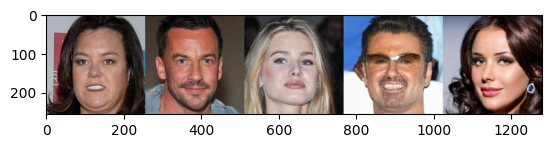

In [17]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

grid = make_grid(
    traj[-1, -5:].view([-1, 3, 256, 256]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

In [18]:
torch.save(model.state_dict(), "model_best.pth")